# Testing and benchmarking data generators + visualizing data

Here I am using a resampled version of the dataset PROSTATE-DIAGNOSIS from TCIA.

## Import packages

In [1]:
import os
import time
import numpy as np
from glob import glob
import torch
from monai.transforms import LoadImage
import pydicom 
import seaborn as sns
import pandas as pd
import torch
from tqdm import tqdm,trange

import matplotlib.pyplot as plt

from lib.data_functions import *

try:  os.makedirs('figures')
except: pass

In [2]:
all_image_readers = {
    'pydicom':read_pydicom,
    'monai:infer':LoadImage(),
    'monai:nibabelreader':LoadImage('nibabelreader'),
    'monai:pilreader':LoadImage('pilreader'),
    'monai:itkreader':LoadImage('itkreader'),
    'monai:numpyreader':LoadImage('numpyreader')
    }

## Testing dataset and data generation

The most crucial aspect of this is automating the padding operation --- only then can we confidently generate batches which have the same dimensions along all axes.

## Benchmarking

In [3]:
dataset_dir_dicom = '../../data/PROSTATE-DIAGNOSIS/PROSTATE-DIAGNOSIS-RESIZED/'
dataset_dir_nifti = '../../data/PROSTATE-DIAGNOSIS/PROSTATE-DIAGNOSIS-RESIZED-NIFTI/'
K = ["T1WTSEAX","T2WTSEAX","T2WTSECOR"]

all_dcm_folders = glob('{}/*'.format(dataset_dir_dicom))
path_dictionary_dicom = {}

for folder in all_dcm_folders:
    folder_name = folder.split(os.sep)[-1]
    path_dictionary_dicom[folder_name] = {}
    for f in glob("{}/*".format(folder)):
        for k in K:
            if k == f.split(os.sep)[-1]:
                path_dictionary_dicom[folder_name][k] = f

all_nifti_folders = glob('{}/*'.format(dataset_dir_nifti))
nifti_cor = {"T1W_TSE_AX":"T1WTSEAX",
             "T2W_TSE_AX":"T2WTSEAX",
             "T2W_TSE_COR":"T2WTSECOR"}
path_dictionary_nifti = {}

for folder in all_nifti_folders:
    folder_name = folder.split(os.sep)[-1]
    path_dictionary_nifti[folder_name] = {}
    for f in glob("{}/*nii".format(folder)):
        for k in nifti_cor:
            if k in f:
                path_dictionary_nifti[folder_name][nifti_cor[k]] = f

### Benchmarking DICOM datasets

#### Single dataset cases

In [4]:
times = {'times':[],'id':[],'modalities':[],'n_modalities':[]}
N_it = 100
for i in range(len(K)):
    dg = K[i:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_dicom,"dicom",padding=True)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_dicom,"dicom",padding=True,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_dicom,"dicom",padding=True,
                                 orientation=None,image_keys=dg)

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times['times'].append(b-a)
        times['id'].append('torchio')
        times['modalities'].append(':'.join(dg))
        times['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times['times'].append(b-a)
        times['id'].append('numpy')
        times['modalities'].append(':'.join(dg))
        times['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times['times'].append(b-a)
        times['id'].append('monai')
        times['modalities'].append(':'.join(dg))
        times['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


current dataset group: ['T2WTSEAX']


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


current dataset group: ['T2WTSECOR']


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


#### Multiple dataset cases

In [5]:
for i in range(len(K)):
    dg = K[0:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_dicom,"dicom",padding=True)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_dicom,"dicom",padding=True,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_dicom,"dicom",padding=True,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times['times'].append(b-a)
        times['id'].append('torchio')
        times['modalities'].append(':'.join(dg))
        times['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times['times'].append(b-a)
        times['id'].append('numpy')
        times['modalities'].append(':'.join(dg))
        times['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times['times'].append(b-a)
        times['id'].append('monai')
        times['modalities'].append(':'.join(dg))
        times['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


### Benchmarking nifti datasets

#### Single dataset cases

In [6]:
times_nifti = {'times':[],'id':[],'modalities':[],'n_modalities':[]}
N_it = 100
for i in range(len(K)):
    dg = K[i:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_nifti,"nifti",padding=True)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_nifti,"nifti",padding=True,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_nifti,"nifti",padding=True,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times_nifti['times'].append(b-a)
        times_nifti['id'].append('torchio')
        times_nifti['modalities'].append(':'.join(dg))
        times_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times_nifti['times'].append(b-a)
        times_nifti['id'].append('numpy')
        times_nifti['modalities'].append(':'.join(dg))
        times_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times_nifti['times'].append(b-a)
        times_nifti['id'].append('monai')
        times_nifti['modalities'].append(':'.join(dg))
        times_nifti['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


current dataset group: ['T2WTSEAX']


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


current dataset group: ['T2WTSECOR']


100%|██████████| 100/100 [00:03<00:00, 25.38it/s]


#### Multiple dataset cases

In [7]:
for i in range(len(K)):
    dg = K[0:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_nifti,"nifti",padding=True)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_nifti,"nifti",padding=True,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_nifti,"nifti",padding=True,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times_nifti['times'].append(b-a)
        times_nifti['id'].append('torchio')
        times_nifti['modalities'].append(':'.join(dg))
        times_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times_nifti['times'].append(b-a)
        times_nifti['id'].append('numpy')
        times_nifti['modalities'].append(':'.join(dg))
        times_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times_nifti['times'].append(b-a)
        times_nifti['id'].append('monai')
        times_nifti['modalities'].append(':'.join(dg))
        times_nifti['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


### Visualizing benchmark

In [8]:
df_times = pd.DataFrame.from_dict(times)
df_times_nifti = pd.DataFrame.from_dict(times_nifti)
df_times['data_type'] = "dicom"
df_times_nifti['data_type'] = "nifti"
df_times_full = pd.concat([df_times,df_times_nifti])
g = sns.catplot(data=df_times_full,y="modalities",x="times",
                hue="id",row="data_type",kind="box",height=2,aspect=5,
                linewidth=0.5,fliersize=0.4)
for k in g.axes_dict:
    g.axes_dict[k].set_xscale('log')
plt.show()

g.savefig("figures/benchmark_padding.pdf")

## Benchmarking (no padding)

### Benchmarking DICOM datasets

#### Single dataset cases

In [9]:
times_no_padding = {'times':[],'id':[],'modalities':[],'n_modalities':[]}
N_it = 100
for i in range(len(K)):
    dg = K[i:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_dicom,"dicom",padding=False)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_dicom,"dicom",padding=False,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_dicom,"dicom",padding=False,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times_no_padding['times'].append(b-a)
        times_no_padding['id'].append('torchio')
        times_no_padding['modalities'].append(':'.join(dg))
        times_no_padding['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times_no_padding['times'].append(b-a)
        times_no_padding['id'].append('numpy')
        times_no_padding['modalities'].append(':'.join(dg))
        times_no_padding['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times_no_padding['times'].append(b-a)
        times_no_padding['id'].append('monai')
        times_no_padding['modalities'].append(':'.join(dg))
        times_no_padding['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


current dataset group: ['T2WTSEAX']


100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


current dataset group: ['T2WTSECOR']


100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


#### Multiple dataset cases

In [10]:
for i in range(len(K)):
    dg = K[0:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_dicom,"dicom",padding=False)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_dicom,"dicom",padding=False,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_dicom,"dicom",padding=False,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times_no_padding['times'].append(b-a)
        times_no_padding['id'].append('torchio')
        times_no_padding['modalities'].append(':'.join(dg))
        times_no_padding['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times_no_padding['times'].append(b-a)
        times_no_padding['id'].append('numpy')
        times_no_padding['modalities'].append(':'.join(dg))
        times_no_padding['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times_no_padding['times'].append(b-a)
        times_no_padding['id'].append('monai')
        times_no_padding['modalities'].append(':'.join(dg))
        times_no_padding['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


### Benchmarking nifti datasets

#### Single dataset cases

In [11]:
times_no_padding_nifti = {'times':[],'id':[],'modalities':[],'n_modalities':[]}
N_it = 100
for i in range(len(K)):
    dg = K[i:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_nifti,"nifti",padding=False)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_nifti,"nifti",padding=False,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_nifti,"nifti",padding=False,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times_no_padding_nifti['times'].append(b-a)
        times_no_padding_nifti['id'].append('torchio')
        times_no_padding_nifti['modalities'].append(':'.join(dg))
        times_no_padding_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times_no_padding_nifti['times'].append(b-a)
        times_no_padding_nifti['id'].append('numpy')
        times_no_padding_nifti['modalities'].append(':'.join(dg))
        times_no_padding_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times_no_padding_nifti['times'].append(b-a)
        times_no_padding_nifti['id'].append('monai')
        times_no_padding_nifti['modalities'].append(':'.join(dg))
        times_no_padding_nifti['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


current dataset group: ['T2WTSEAX']


100%|██████████| 100/100 [00:02<00:00, 44.39it/s]


current dataset group: ['T2WTSECOR']


100%|██████████| 100/100 [00:01<00:00, 69.20it/s]


#### Multiple dataset cases

In [12]:
for i in range(len(K)):
    dg = K[0:(i+1)]
    torchio_dataset = TorchIODataset(path_dictionary_nifti,"nifti",padding=False)
    torchio_dataset.mod_keys = dg

    numpy_dataset = NumpyDataset(path_dictionary_nifti,"nifti",padding=False,to_tensor=True)
    numpy_dataset.mod_keys = dg
    
    monai_dataset = MONAIDataset(path_dictionary_nifti,"nifti",padding=False,orientation=None,
                                 image_keys=dg)
    monai_dataset.mod_keys = dg    

    print("current dataset group: {}".format(dg))
    for _ in trange(N_it):
        x = np.random.randint(len(torchio_dataset))
        a = time.time()
        torchio_dataset[x]
        b = time.time()
        times_no_padding_nifti['times'].append(b-a)
        times_no_padding_nifti['id'].append('torchio')
        times_no_padding_nifti['modalities'].append(':'.join(dg))
        times_no_padding_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        numpy_dataset[x]
        b = time.time()
        times_no_padding_nifti['times'].append(b-a)
        times_no_padding_nifti['id'].append('numpy')
        times_no_padding_nifti['modalities'].append(':'.join(dg))
        times_no_padding_nifti['n_modalities'].append(len(dg))
        
        a = time.time()
        monai_dataset[x]
        b = time.time()
        times_no_padding_nifti['times'].append(b-a)
        times_no_padding_nifti['id'].append('monai')
        times_no_padding_nifti['modalities'].append(':'.join(dg))
        times_no_padding_nifti['n_modalities'].append(len(dg))

current dataset group: ['T1WTSEAX']


100%|██████████| 100/100 [00:02<00:00, 37.49it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 100/100 [00:04<00:00, 21.71it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


### Visualizing benchmark

In [13]:
df_times_no_padding = pd.DataFrame.from_dict(times_no_padding)
df_times_no_padding_nifti = pd.DataFrame.from_dict(times_no_padding_nifti)
df_times_no_padding['data_type'] = "dicom"
df_times_no_padding_nifti['data_type'] = "nifti"
df_times_no_padding_full = pd.concat(
    [df_times_no_padding,df_times_no_padding_nifti])
g = sns.catplot(data=df_times_no_padding_full,y="modalities",x="times",
                hue="id",row="data_type",kind="box",height=2,aspect=5,
                linewidth=0.5,fliersize=0.4)
for k in g.axes_dict:
    g.axes_dict[k].set_xscale('log')
plt.show()

g.savefig("figures/benchmark_no_padding.pdf")

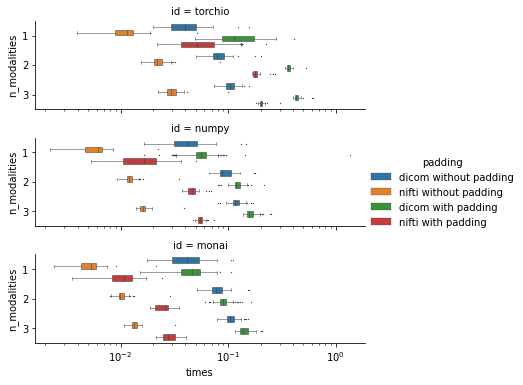

In [14]:
df_times_no_padding_full['padding'] = df_times_no_padding_full['data_type'] + ' without padding'
df_times_full['padding'] = df_times_full['data_type'] + ' with padding'

df_times_all = pd.concat([df_times_no_padding_full,df_times_full])
df_times_all['n_modalities'] = df_times_all['n_modalities'].astype(str)
df_times_all.sort_values(["n_modalities","padding"])
g = sns.catplot(data=df_times_all,y="n_modalities",x="times",
                hue="padding",row="id",kind="box",height=1.8,aspect=3,
                linewidth=0.5,fliersize=0.4)
for k in g.axes_dict:
    g.axes_dict[k].set_xscale('log')
plt.show()

g.savefig("figures/benchmark_padding_vs_no_padding.pdf")

### Quick assessment for DataLoader (w/ batches)

In [15]:
batch_size = 4
n_workers = 4
torchio_dataset = torch.utils.data.DataLoader(
    TorchIODataset(path_dictionary_dicom,"dicom",padding=True),
    batch_size=batch_size,num_workers=n_workers,drop_last=True)
torchio_dataset.mod_keys = dg

a = time.time()
torchio_iterator = iter(torchio_dataset)
for _ in range(len(torchio_dataset)):
    torchio_batch = next(torchio_iterator)
b = time.time()

c = time.time()
for torchio_batch in iter(torchio_dataset):
    pass
d = time.time()

print(b-a,d-c)

18.655470609664917 18.624027490615845


In [16]:
N_passes = 4
batch_size = 4
times_batch = {'times':[],'id':[],'modalities':[],
               'n_modalities':[],'n_workers':[]}

for n_workers in [0,2,4]:
    print("Current n_workers",n_workers)
    for i in range(len(K)):
        dg = K[0:(i+1)]
        torchio_dataset = torch.utils.data.DataLoader(
            TorchIODataset(path_dictionary_dicom,"dicom",padding=True),
            batch_size=batch_size,num_workers=n_workers,drop_last=True)
        torchio_dataset.mod_keys = dg

        numpy_dataset = torch.utils.data.DataLoader(
            NumpyDataset(path_dictionary_dicom,"dicom",padding=True,to_tensor=True),
            batch_size=batch_size,num_workers=n_workers,drop_last=True)
        numpy_dataset.mod_keys = dg
        
        monai_dataset = torch.utils.data.DataLoader(
            MONAIDataset(path_dictionary_dicom,"dicom",padding=True,orientation=None,image_keys=dg),
            batch_size=batch_size,num_workers=n_workers,drop_last=True)
        monai_dataset.mod_keys = dg
        
        print("current dataset group: {}".format(dg))
        up = trange(len(torchio_dataset.dataset)//batch_size * 3 * N_passes)
        for _ in range(N_passes):
            torchio_iterator = iter(torchio_dataset)
            for _ in range(len(torchio_dataset)):
                a = time.time()
                torchio_batch = next(torchio_iterator)
                b = time.time()
                times_batch['times'].append(b-a)
                times_batch['id'].append('torchio')
                times_batch['modalities'].append(':'.join(dg))
                times_batch['n_modalities'].append(len(dg))
                times_batch['n_workers'].append(n_workers)
                up.update()
                
            numpy_iterator = iter(numpy_dataset)
            for _ in range(len(numpy_dataset)):
                a = time.time()
                numpy_batch = next(numpy_iterator)
                b = time.time()
                times_batch['times'].append(b-a)
                times_batch['id'].append('numpy')
                times_batch['modalities'].append(':'.join(dg))
                times_batch['n_modalities'].append(len(dg))
                times_batch['n_workers'].append(n_workers)
                up.update()
            
            monai_iterator = iter(monai_dataset)
            for _ in range(len(monai_dataset)):
                a = time.time()
                monai_batch = next(monai_iterator)
                b = time.time()                
                times_batch['times'].append(b-a)
                times_batch['id'].append('monai')
                times_batch['modalities'].append(':'.join(dg))
                times_batch['n_modalities'].append(len(dg))
                times_batch['n_workers'].append(n_workers)
                up.update()

Current n_workers 0
current dataset group: ['T1WTSEAX']


100%|██████████| 240/240 [03:58<00:00,  3.54it/s]

current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 240/240 [03:58<00:00,  1.00it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 240/240 [04:15<00:00,  1.95it/s]

Current n_workers 2
current dataset group: ['T1WTSEAX']


100%|██████████| 240/240 [04:16<00:00,  1.07s/it]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|█████████▉| 239/240 [02:59<00:00,  3.73it/s]

current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 240/240 [03:00<00:00,  1.33it/s]


Current n_workers 4
current dataset group: ['T1WTSEAX']


100%|█████████▉| 239/240 [01:44<00:00, 10.61it/s]

current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 240/240 [01:45<00:00,  2.28it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|█████████▉| 239/240 [01:57<00:00,  5.16it/s]

In [17]:
batch_size = 4
times_batch_nifti = {'times':[],'id':[],'modalities':[],'n_modalities':[],'n_workers':[]}

for n_workers in [0,2,4]:
    print("Current n_workers",n_workers)
    for i in range(len(K)):
        dg = K[0:(i+1)]
        torchio_dataset = torch.utils.data.DataLoader(
            TorchIODataset(path_dictionary_nifti,"nifti",padding=True),
            batch_size=batch_size,num_workers=n_workers,drop_last=True)
        torchio_iterator = iter(torchio_dataset)
        torchio_dataset.mod_keys = dg

        numpy_dataset = torch.utils.data.DataLoader(
            NumpyDataset(path_dictionary_nifti,"nifti",padding=True,to_tensor=True),
            batch_size=batch_size,num_workers=n_workers,drop_last=True)
        numpy_iterator = iter(numpy_dataset)
        numpy_dataset.mod_keys = dg
        
        monai_dataset = torch.utils.data.DataLoader(
            MONAIDataset(path_dictionary_nifti,"nifti",padding=True,orientation=None,image_keys=dg),
            batch_size=batch_size,num_workers=n_workers,drop_last=True)
        monai_iterator = iter(monai_dataset)
        monai_dataset.mod_keys = dg    

        print("current dataset group: {}".format(dg))
        up = trange(len(torchio_dataset.dataset)//batch_size * 3 * N_passes)
        for _ in range(N_passes):
            torchio_iterator = iter(torchio_dataset)
            for _ in range(len(torchio_dataset)):
                a = time.time()
                torchio_batch = next(torchio_iterator)
                b = time.time()
                times_batch_nifti['times'].append(b-a)
                times_batch_nifti['id'].append('torchio')
                times_batch_nifti['modalities'].append(':'.join(dg))
                times_batch_nifti['n_modalities'].append(len(dg))
                times_batch_nifti['n_workers'].append(n_workers)
                up.update()
                
            numpy_iterator = iter(numpy_dataset)
            for _ in range(len(numpy_dataset)):
                a = time.time()
                numpy_batch = next(numpy_iterator)
                b = time.time()
                times_batch_nifti['times'].append(b-a)
                times_batch_nifti['id'].append('numpy')
                times_batch_nifti['modalities'].append(':'.join(dg))
                times_batch_nifti['n_modalities'].append(len(dg))
                times_batch_nifti['n_workers'].append(n_workers)
                up.update()
            
            monai_iterator = iter(monai_dataset)
            for _ in range(len(monai_dataset)):
                a = time.time()
                monai_batch = next(monai_iterator)
                b = time.time()                
                times_batch_nifti['times'].append(b-a)
                times_batch_nifti['id'].append('monai')
                times_batch_nifti['modalities'].append(':'.join(dg))
                times_batch_nifti['n_modalities'].append(len(dg))
                times_batch_nifti['n_workers'].append(n_workers)
                up.update()

Current n_workers 0
current dataset group: ['T1WTSEAX']


100%|██████████| 240/240 [01:58<00:00,  2.03it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 240/240 [01:54<00:00,  7.21it/s]

current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 240/240 [01:54<00:00,  2.09it/s]


Current n_workers 2
current dataset group: ['T1WTSEAX']


100%|█████████▉| 239/240 [01:33<00:00, 15.48it/s]

current dataset group: ['T1WTSEAX', 'T2WTSEAX']


100%|██████████| 240/240 [01:34<00:00,  2.55it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|█████████▉| 239/240 [01:44<00:00,  5.77it/s]

Current n_workers 4
current dataset group: ['T1WTSEAX']


100%|██████████| 240/240 [01:46<00:00,  2.26it/s]


current dataset group: ['T1WTSEAX', 'T2WTSEAX']


 99%|█████████▉| 238/240 [01:06<00:00,  9.60it/s]

current dataset group: ['T1WTSEAX', 'T2WTSEAX', 'T2WTSECOR']


100%|██████████| 240/240 [01:07<00:00,  3.54it/s]


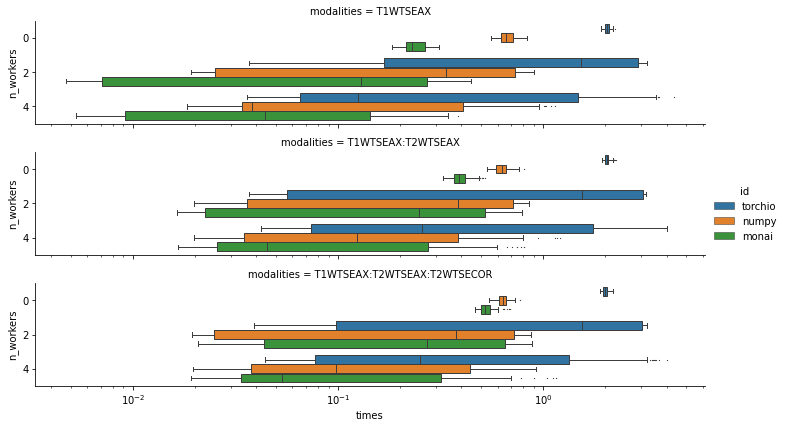

In [18]:
df_times_batch = pd.DataFrame.from_dict(times_batch)
df_times_batch['n_workers'] = df_times_batch['n_workers'].astype(str)
df_times_batch_nifti = pd.DataFrame.from_dict(times_batch_nifti)
df_times_batch_nifti['n_workers'] = df_times_batch_nifti['n_workers'].astype(str)
df_times_batch['data_type'] = "dicom"
df_times_batch_nifti['data_type'] = "nifti"
df_times_batch_full = pd.concat(
    [df_times_batch,df_times_batch_nifti])
g = sns.catplot(data=df_times_batch,y="n_workers",x="times",
                hue="id",row="modalities",kind="box",height=2,aspect=5,
                linewidth=1,fliersize=0.4)
for k in g.axes_dict:
    g.axes_dict[k].set_xscale('log')
plt.show()

g.savefig("figures/benchmark_dataloader_dicom.pdf")

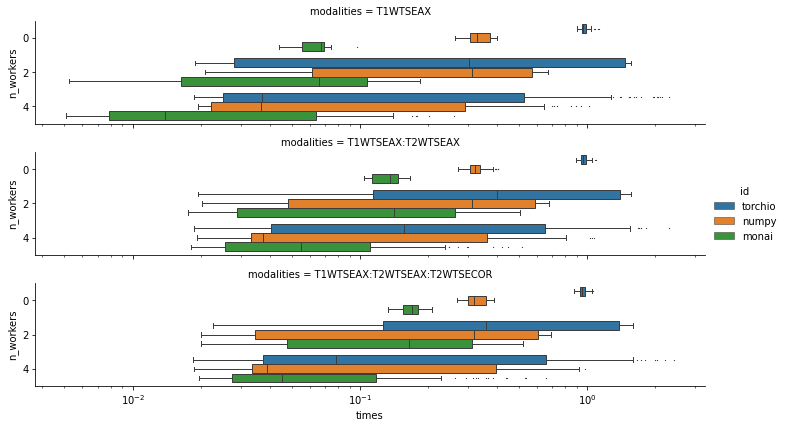

In [19]:
g = sns.catplot(data=df_times_batch_nifti,y="n_workers",x="times",
                hue="id",row="modalities",kind="box",height=2,aspect=5,
                linewidth=1,fliersize=0.4)
for k in g.axes_dict:
    g.axes_dict[k].set_xscale('log')
plt.show()

g.savefig("figures/benchmark_dataloader_nifti.pdf")

In [20]:
df_times_batch_agg = df_times_batch_full.groupby(
    ["modalities","id","n_workers","data_type"]).agg(
    {"times":[lambda x: np.quantile(x,0.05),
              lambda x: np.quantile(x,0.5),
              lambda x: np.quantile(x,0.95)]}).reset_index()

df_times_batch_agg.columns = ['modalities','id','n_workers','data_type','q05','q50','q95']

df_times_batch_agg

modalities       id n_workers data_type       q05  \
0                      T1WTSEAX    monai         0     dicom  0.197669   
1                      T1WTSEAX    monai         0     nifti  0.049997   
2                      T1WTSEAX    monai         2     dicom  0.005579   
3                      T1WTSEAX    monai         2     nifti  0.005600   
4                      T1WTSEAX    monai         4     dicom  0.005350   
5                      T1WTSEAX    monai         4     nifti  0.005733   
6                      T1WTSEAX    numpy         0     dicom  0.574039   
7                      T1WTSEAX    numpy         0     nifti  0.284554   
8                      T1WTSEAX    numpy         2     dicom  0.020557   
9                      T1WTSEAX    numpy         2     nifti  0.031728   
10                     T1WTSEAX    numpy         4     dicom  0.020884   
11                     T1WTSEAX    numpy         4     nifti  0.019866   
12                     T1WTSEAX  torchio         0     dicom  1.962210   
13                     T1WTSEAX  torchio         0     nifti  0.926750   
14                     T1WTSEAX  torchio         2     dicom  0.043958   
15                     T1WTSEAX  torchio         2     nifti  0.020863   
16                     T1WTSEAX  torchio         4     dicom  0.041424   
17                     T1WTSEAX  torchio         4     nifti  0.019071   
18            T1WTSEAX:T2WTSEAX    monai         0     dicom  0.342435   
19            T1WTSEAX:T2WTSEAX    monai         0     nifti  0.108473   
20            T1WTSEAX:T2WTSEAX    monai         2     dicom  0.018064   
21            T1WTSEAX:T2WTSEAX    monai         2     nifti  0.018623   
22            T1WTSEAX:T2WTSEAX    monai         4     dicom  0.018275   
23            T1WTSEAX:T2WTSEAX    monai         4     nifti  0.018868   
24            T1WTSEAX:T2WTSEAX    numpy         0     dicom  0.547632   
25            T1WTSEAX:T2WTSEAX    numpy         0     nifti  0.274789   
26            T1WTSEAX:T2WTSEAX    numpy         2     dicom  0.020297   
27            T1WTSEAX:T2WTSEAX    numpy         2     nifti  0.024702   
28            T1WTSEAX:T2WTSEAX    numpy         4     dicom  0.022112   
29            T1WTSEAX:T2WTSEAX    numpy         4     nifti  0.019903   
30            T1WTSEAX:T2WTSEAX  torchio         0     dicom  1.957109   
31            T1WTSEAX:T2WTSEAX  torchio         0     nifti  0.924851   
32            T1WTSEAX:T2WTSEAX  torchio         2     dicom  0.041875   
33            T1WTSEAX:T2WTSEAX  torchio         2     nifti  0.025619   
34            T1WTSEAX:T2WTSEAX  torchio         4     dicom  0.044590   
35            T1WTSEAX:T2WTSEAX  torchio         4     nifti  0.021458   
36  T1WTSEAX:T2WTSEAX:T2WTSECOR    monai         0     dicom  0.477574   
37  T1WTSEAX:T2WTSEAX:T2WTSECOR    monai         0     nifti  0.138668   
38  T1WTSEAX:T2WTSEAX:T2WTSECOR    monai         2     dicom  0.022476   
39  T1WTSEAX:T2WTSEAX:T2WTSECOR    monai         2     nifti  0.021303   
40  T1WTSEAX:T2WTSEAX:T2WTSECOR    monai         4     dicom  0.020356   
41  T1WTSEAX:T2WTSEAX:T2WTSECOR    monai         4     nifti  0.021489   
42  T1WTSEAX:T2WTSEAX:T2WTSECOR    numpy         0     dicom  0.572967   
43  T1WTSEAX:T2WTSEAX:T2WTSECOR    numpy         0     nifti  0.275609   
44  T1WTSEAX:T2WTSEAX:T2WTSECOR    numpy         2     dicom  0.020708   
45  T1WTSEAX:T2WTSEAX:T2WTSECOR    numpy         2     nifti  0.021141   
46  T1WTSEAX:T2WTSEAX:T2WTSECOR    numpy         4     dicom  0.021753   
47  T1WTSEAX:T2WTSEAX:T2WTSECOR    numpy         4     nifti  0.021084   
48  T1WTSEAX:T2WTSEAX:T2WTSECOR  torchio         0     dicom  1.924761   
49  T1WTSEAX:T2WTSEAX:T2WTSECOR  torchio         0     nifti  0.899988   
50  T1WTSEAX:T2WTSEAX:T2WTSECOR  torchio         2     dicom  0.042445   
51  T1WTSEAX:T2WTSEAX:T2WTSECOR  torchio         2     nifti  0.040698   
52  T1WTSEAX:T2WTSEAX:T2WTSECOR  torchio         4     dicom  0.047889   
53  T1WTSEAX:T2WTSEAX:T2W

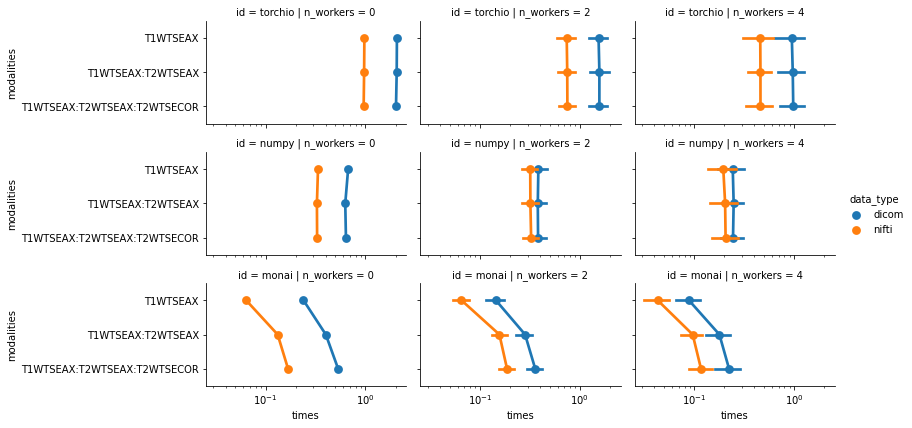

In [21]:
g = sns.catplot(x="times",y="modalities",row="id",col="n_workers",hue="data_type",
                data=df_times_batch_full,height=2,aspect=2,kind='point')

for k in g.axes_dict:
    g.axes_dict[k].set_xscale('log')
    
g.savefig("figures/benchmark_dataloader_full.pdf")